**Student Name**: Chandresh J. Sutariya

**Student Roll No**: 21f3001415

# diff. between sarsa and q_learning I see:
I am adding it here Because I think its the most important!

in q learning the required step to converge is "relatively" with sarsa lesse.

SARSA took very high steps for each episode to converge.

I think this is because of choosing Max.Q value over all possible action in the TD update rule in q-learning

# Programming Assignment-2


Make a copy of the colab. Rename the colab as follows:

```
PA-2_<roll-number>.ipynb
```

We will be running your colab. It should produce the graphs/charts as explaind in the problem statements. Add comments wherever necessary. At the end of each problem configuration, enter your observations in the text cell. This should include your analysis of the learning curves obtaind.

### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [502]:
# import necessary libraries here
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np


seed = 42
np.random.seed(seed)

## Environment description

This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. You will solve several variants of the Grid World problem (a sample world is shown below in Figure 1).

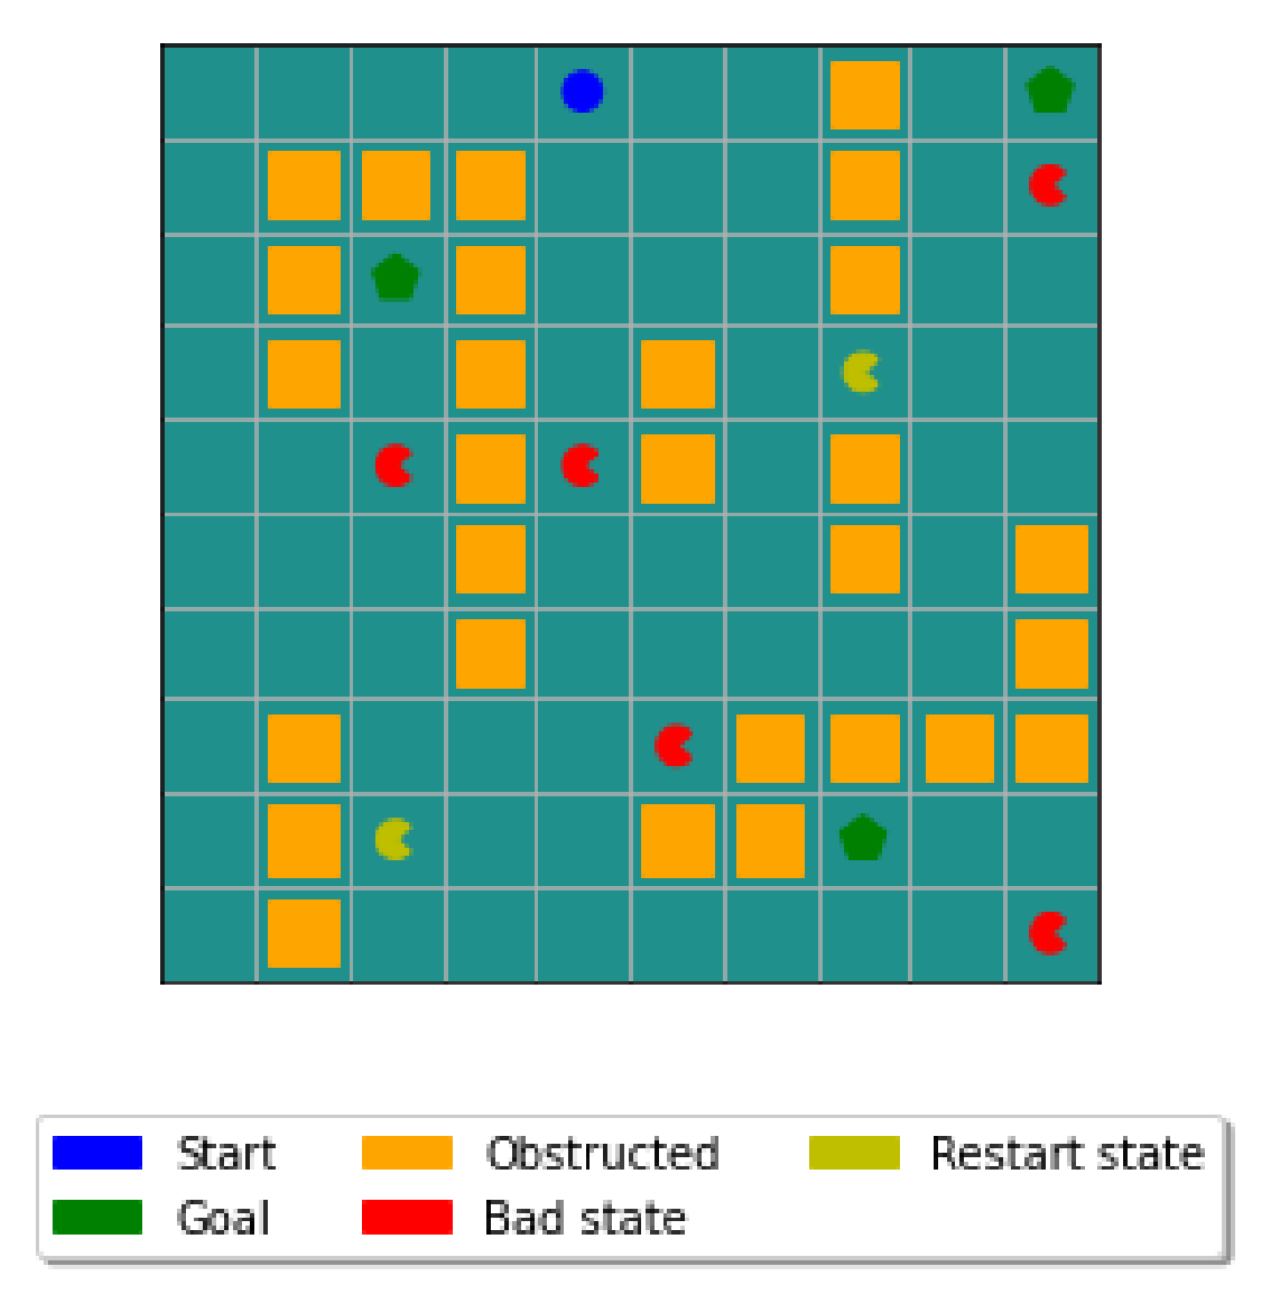

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

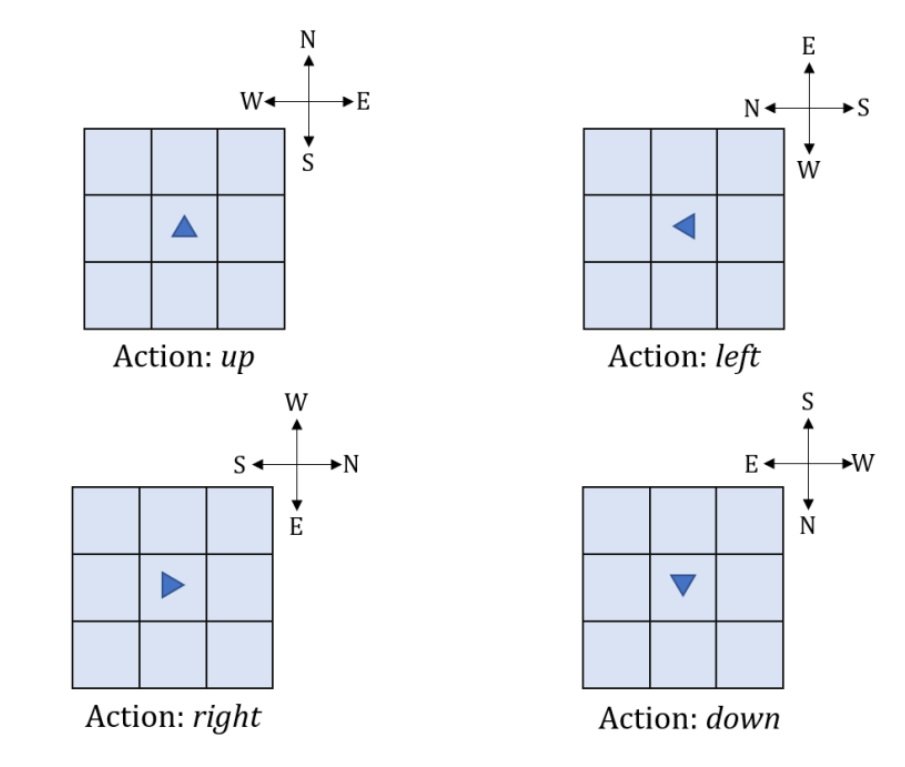

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [503]:
#@title environment
#Converts state number to row_column format
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]

#Converts row_column format to state number
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):
          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Environment instantiation

In [504]:
#@title env.instantiation
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

## Visualize the grid world

In [505]:
# visualize the grid world configuration
env.visualize_gridworld()

## List environment variables

In [506]:
#@title env variables
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Tasks
- Implement SARSA and Q-Learning.
- ~~For each algorithm, run experiments with wind=False and wind=True; two different start states: (0, 4), (3, 6); two values of $p$ (1.0, 0.7); and two types of exploration strategies ($\epsilon$-greedy and softmax), making it ***16 different configurations*** in total.~~
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

For each of the algorithm, provide a written description of the policy learnt, explaining
the behavior of the agent, and your choice of hyperparameters. This description should
also provide information about how the behavior changes with and without the wind, for
different levels of stochasticity and for different start states.

The report can be organized in following manner:

In [507]:
configurations_for_sarsa = [{'alpha': 0.001, 'gamma': 0.7, 'epsilon': 0.001},
                            {'alpha': 0.01, 'gamma': 0.8, 'epsilon': 0.01},
                            {'alpha': 0.1, 'gamma': 0.9, 'epsilon': 0.05},
                            {'alpha': 1, 'gamma': 1, 'epsilon': 0.1},
                            {'alpha': 0.001, 'gamma': 0.7, 'epsilon': 0.001},
                            {'alpha': 0.01, 'gamma': 0.8, 'epsilon': 0.01},
                            {'alpha': 0.1, 'gamma': 0.9, 'epsilon': 0.05},
                            {'alpha': 1, 'gamma': 1, 'epsilon': 0.1},]

In [508]:
configurations_for_q_learning = [{'alpha': 0.001, 'gamma': 0.7, 'epsilon': 0.001},
                                  {'alpha': 0.01, 'gamma': 0.8, 'epsilon': 0.01},
                                  {'alpha': 0.1, 'gamma': 0.9, 'epsilon': 0.05},
                                  {'alpha': 1, 'gamma': 1, 'epsilon': 0.1},
                                  {'alpha': 0.001, 'gamma': 0.7, 'epsilon': 0.001},
                                  {'alpha': 0.01, 'gamma': 0.8, 'epsilon': 0.01},
                                  {'alpha': 0.1, 'gamma': 0.9, 'epsilon': 0.05},
                                  {'alpha': 1, 'gamma': 1, 'epsilon': 0.1},]

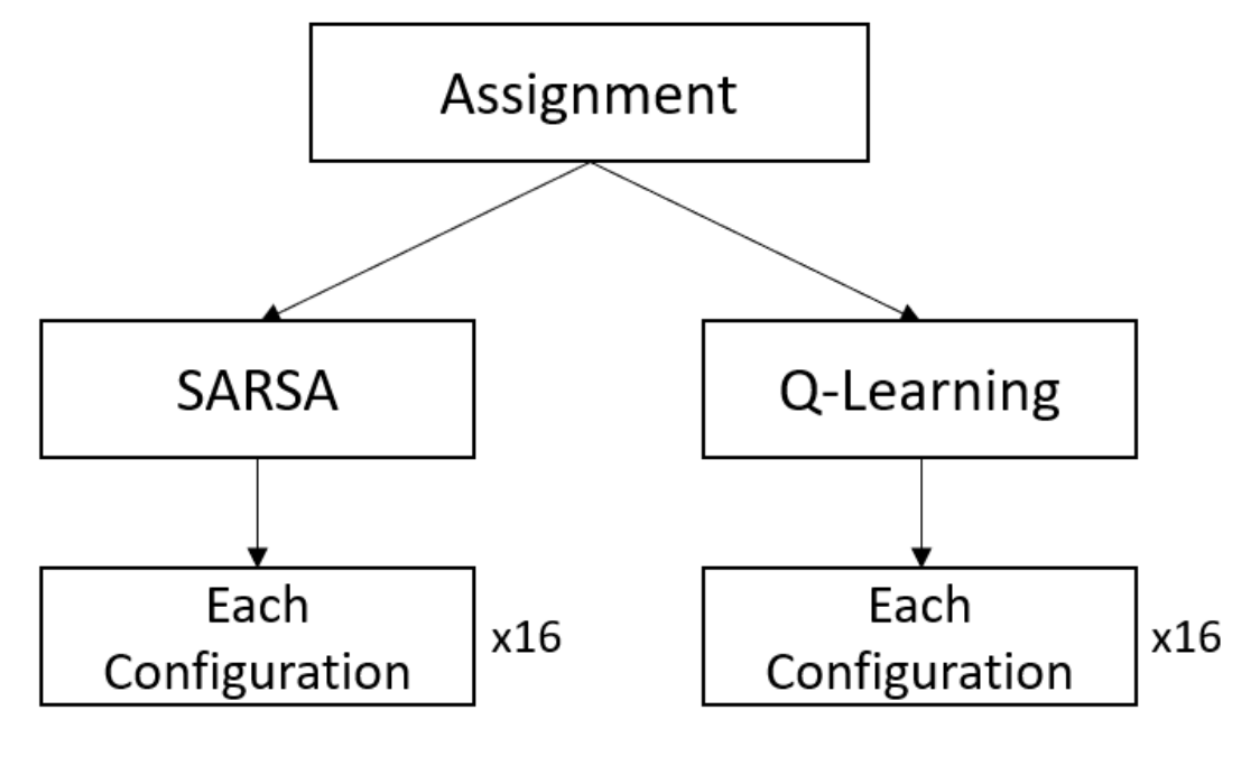

## Configurations [64 Marks]

There are total (~~32~~)16 configurations (~~16~~)8 each for SARSA and Q-Learning), each of which carry (~~2~~)4 marks.

Use below template for each of the configurations.

Hint: For reproducible results set random state appropriately.

Train the agent

In [509]:
#@title e_greedy function to select an action
def e_greedy(q_of_s, epsilon):
  actions = list(q_of_s.keys())
  a_star =  np.argmax([q_of_s[each] for each in actions])
  # print(a_star)

  prob = [epsilon/len(actions) for each in actions]
  prob[a_star] += (1 - epsilon)
  # print(prob)

  return np.random.choice(actions, p=prob)

In [510]:
#@title SARSA implementations function
def sarsa(conf, num_episodes):

  # starting position
  start_state = np.array([[0,4]])

  # create the environment's model
  gw_s1 = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_state,
                goal_states=goal_states,
                wind = False)

  gw_s1.add_obstructions(obstructed_states=obstructions,
                      bad_states=bad_states,
                      restart_states=restart_states)

  gw_s1.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
  gw_s1.add_transition_probability(p_good_transition=1,    # p
                                bias=0.5)               # b
  env = gw_s1.create_gridworld()


  # SARSA code:
  q = {(row, col): {a: 0 for a in range(4)} for row in range(num_rows) for col in range(num_cols)}
  # print(q)
  total_reward=0

  # analytical quantities
  episodic_reward_list = {each:0 for each in range(num_episodes)}
  episodic_steps_list = {each:0 for each in range(num_episodes)}
  states_visit_count = {(row, col): 0 for row in range(num_rows) for col in range(num_cols)}


  for episode in range(num_episodes):
      episodic_reward = 0
      episodic_steps = 0
      s = tuple([0,4])
      a = e_greedy(q[s], conf['epsilon'])

      while True:
          next_s, reward = env.step(row_col_to_seq(np.array([[s[0], s[1]]]), num_cols)[0], a)

          episodic_steps+= 1                            # incrementing the episodic step
          states_visit_count[s]+=1                      # incrementing the state visit count
          total_reward += reward                        #incrementing the total reward
          episodic_reward +=reward                      #INCrementing episodic reward

          next_s = tuple(seq_to_col_row(next_s, num_cols)[0])
          next_a = e_greedy(q[next_s], conf['epsilon'])

          # print('reward:', reward[0])                         # debuggin, turnsout that the reward is a list!

          # SARSA update rule
          q[s][a] += conf['alpha'] * (reward[0] + conf['gamma'] * q[next_s][next_a] - q[s][a])

          if next_s in [(goal_state[0], goal_state[1]) for goal_state in goal_states]:
              episodic_reward_list[episode]+=episodic_reward               # appending apisodic reward to the list episode_reward and setting it to zero
              episodic_steps_list[episode]+=episodic_steps
              break
          if reward == -100:
            episodic_reward_list[episode]+=episodic_reward               # appending apisodic reward to the list episode_reward and setting it to zero
            episodic_steps_list[episode]+=episodic_steps
            break                                         # goes to start state - the s defines as start state
          s, a = next_s, next_a

  return episodic_reward_list, episodic_steps_list, states_visit_count, q

In [511]:
#@title q_learning fucntion code
# write your code here
def q_learning(conf, num_episodes):

  # starting position
  start_state = np.array([[0,4]])

  # create the environment's model
  gw_s1 = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_state,
                goal_states=goal_states,
                wind = False)

  gw_s1.add_obstructions(obstructed_states=obstructions,
                      bad_states=bad_states,
                      restart_states=restart_states)

  gw_s1.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
  gw_s1.add_transition_probability(p_good_transition=1,    # p
                                bias=0.5)               # b
  env = gw_s1.create_gridworld()


  # Q_LEARNING code:
  q = {(row, col): {a: 0 for a in range(4)} for row in range(num_rows) for col in range(num_cols)}
  # print(q)
  total_reward=0

  # analytical quantities
  episodic_reward_list = {each:0 for each in range(num_episodes)}
  episodic_steps_list = {each:0 for each in range(num_episodes)}
  states_visit_count = {(row, col): 0 for row in range(num_rows) for col in range(num_cols)}


  for episode in range(num_episodes):
      episodic_reward = 0
      episodic_steps = 0
      s = tuple([0,4])
      a = e_greedy(q[s], conf['epsilon'])

      while True:
          next_s, reward = env.step(row_col_to_seq(np.array([[s[0], s[1]]]), num_cols)[0], a)

          episodic_steps+= 1                            # incrementing the episodic step
          states_visit_count[s]+=1                      # incrementing the state visit count
          total_reward += reward                        #incrementing the total reward
          episodic_reward +=reward                      #INCrementing episodic reward

          next_s = tuple(seq_to_col_row(next_s, num_cols)[0])
          next_a = e_greedy(q[next_s], conf['epsilon'])

          next_max_q_on_a = max(q[next_s].values())

          # Q_LEARNING update rule
          q[s][a] += conf['alpha'] * (reward[0] + conf['gamma'] * next_max_q_on_a - q[s][a])

          if next_s in [(goal_state[0], goal_state[1]) for goal_state in goal_states]:
              episodic_reward_list[episode]+=episodic_reward               # appending apisodic reward to the list episode_reward and setting it to zero
              episodic_steps_list[episode]+=episodic_steps
              break
          if reward == -100:
            episodic_reward_list[episode]+=episodic_reward               # appending apisodic reward to the list episode_reward and setting it to zero
            episodic_steps_list[episode]+=episodic_steps
            break                                         # goes to start state - the s defines as start state
          s, a = next_s, next_a

  return episodic_reward_list, episodic_steps_list, states_visit_count, q

### (1) Configuration id SARSA1

1.   List item
2.   List item



#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = e-greedy

In [512]:
conf={
    'start_state':[0,4],
    'wind': False,
    'p': 1,
    'exploration_strategy': 'e-greedy',
    'epsilon': 0.01,
    'num_episodes': 1000,
    'alpha': 0.1,
    'gamma': 0.9
}

# Call the SARSA function
episodic_reward_list, episodic_steps_list, states_visit_count, q = sarsa(conf, 1000)
# print(reward)

1. Plot reward curves (during the training phase with the best hyperparameters).

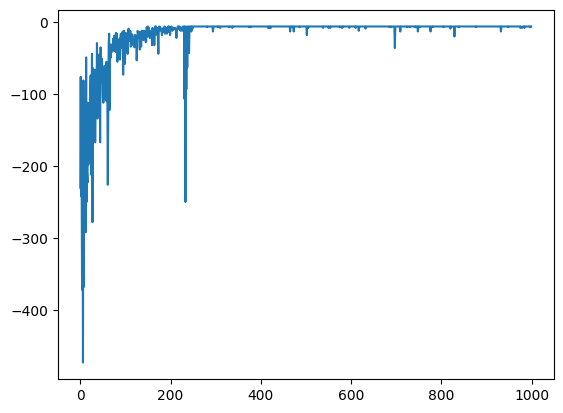

In [513]:
#@title episode # vs Reward
# write your code here
# on x-axis episode number, and on y-axis reward value
import matplotlib.pyplot as plt
plt.plot(episodic_reward_list.keys(), episodic_reward_list.values())
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

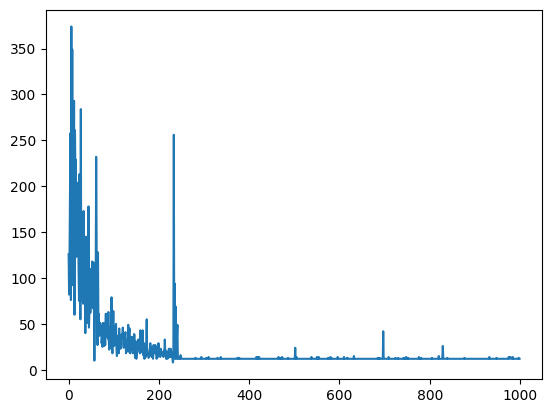

In [514]:
#@title episode # vs steps
# write your code here
# on x-axis the episode number, and on y-axis number of steps to reach the goal
plt.plot(episodic_steps_list.keys(), episodic_steps_list.values())
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

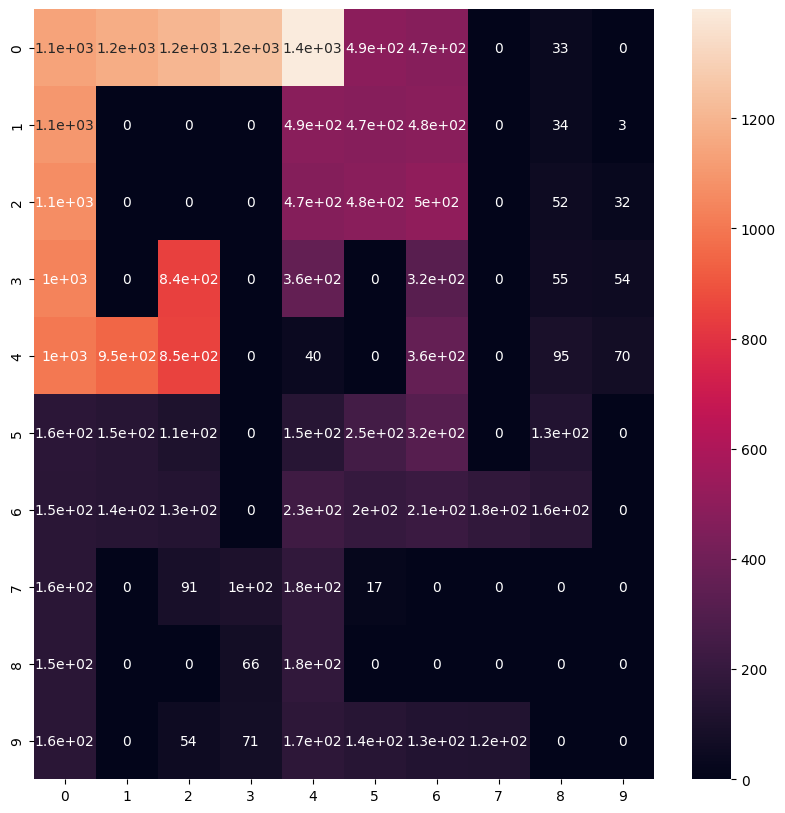

In [515]:
#@title heatmap of # of each state visited for all episodes
# write your code here
# heat map of number of times each state is visited
import seaborn as sns

visit_count_array = np.zeros((num_rows, num_cols))
for (row, col), count in states_visit_count.items():
    visit_count_array[row, col] = count


# plt.figure(figsize(10,10))
plt.figure(figsize=(10,10))
sns.heatmap(visit_count_array, annot=True)
plt.show()


4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

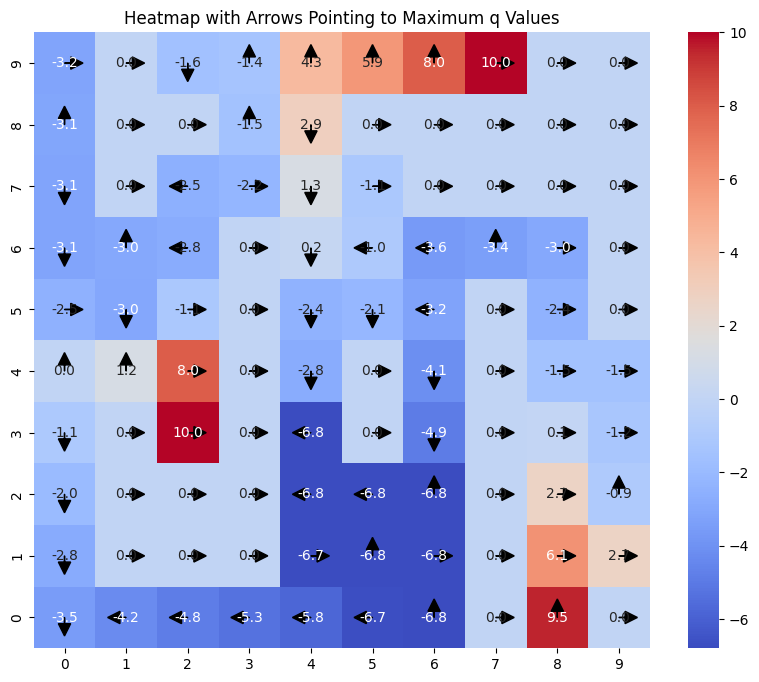

In [516]:
# write your code here
# write your code hereimport numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

heatmap_data = np.zeros((10, 10))

# Populate the heatmap data with the maximum q value for each state
for (i, j), actions in q.items():
    heatmap_data[i, j] = max(actions.values())

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, square=True)

# Adding arrows pointing to the maximum q value of each state
for (i, j), actions in q.items():
    max_action = max(actions, key=actions.get)
    if max_action == 0:  # Right
        dx, dy = 1, 0
    elif max_action == 1:  # Up
        dx, dy = 0, -1
    elif max_action == 2:  # Left
        dx, dy = -1, 0
    elif max_action == 3:  # Down
        dx, dy = 0, 1
    plt.arrow(j + 0.5, i + 0.5, dx * 0.3, dy * 0.3, color='black', head_width=0.2, head_length=0.2, length_includes_head=True)

plt.title("Heatmap with Arrows Pointing to Maximum q Values")
plt.gca().invert_yaxis()  # To match the grid orientation
plt.show()


In [517]:
#@title avg_reward ( on episode )
avg_reward = np.mean(list(episodic_reward_list.values()))
print(avg_reward)

-17.178


In [518]:
#@title avg steps ( on episode )
avg_number_steps_to_reach_goal = np.mean(list(episodic_steps_list.values()))
print(avg_number_steps_to_reach_goal)

22.853


### (2) Configuration id q_learning1

1.   List item
2.   List item



1.   List item
2.   List item



#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = e-greedy

In [519]:
conf={
    'start_state':[0,4],
    'wind': False,
    'p': 1,
    'exploration_strategy': 'e-greedy',
    'epsilon': 0.01,
    'num_episodes': 1000,
    'alpha': 0.1,
    'gamma': 0.9
}

# Call the SARSA function
episodic_reward_list, episodic_steps_list, states_visit_count, q = q_learning(conf, 1000)
# print(reward)

1. Plot reward curves (during the training phase with the best hyperparameters).

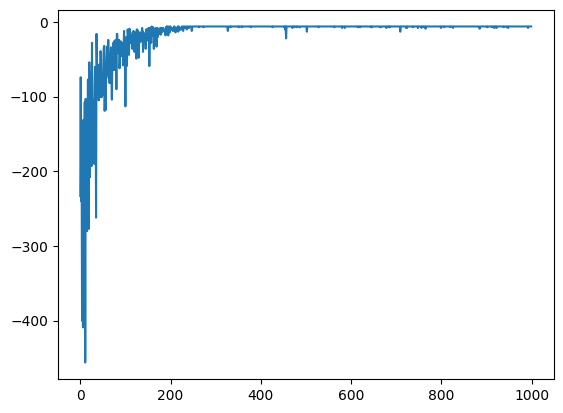

In [520]:
#@title episode # vs Reward
# write your code here
# on x-axis episode number, and on y-axis reward value
import matplotlib.pyplot as plt
plt.plot(episodic_reward_list.keys(), episodic_reward_list.values())
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

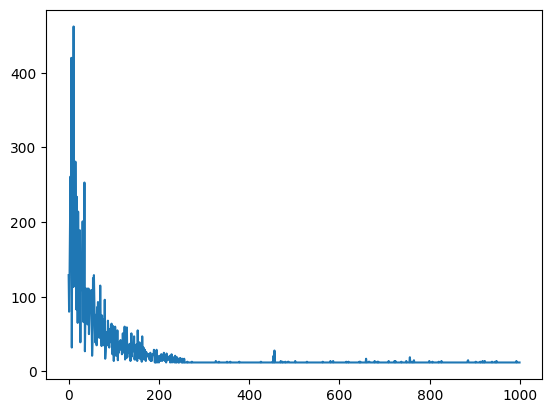

In [521]:
#@title episode # vs steps
# write your code here
# on x-axis the episode number, and on y-axis number of steps to reach the goal
plt.plot(episodic_steps_list.keys(), episodic_steps_list.values())
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

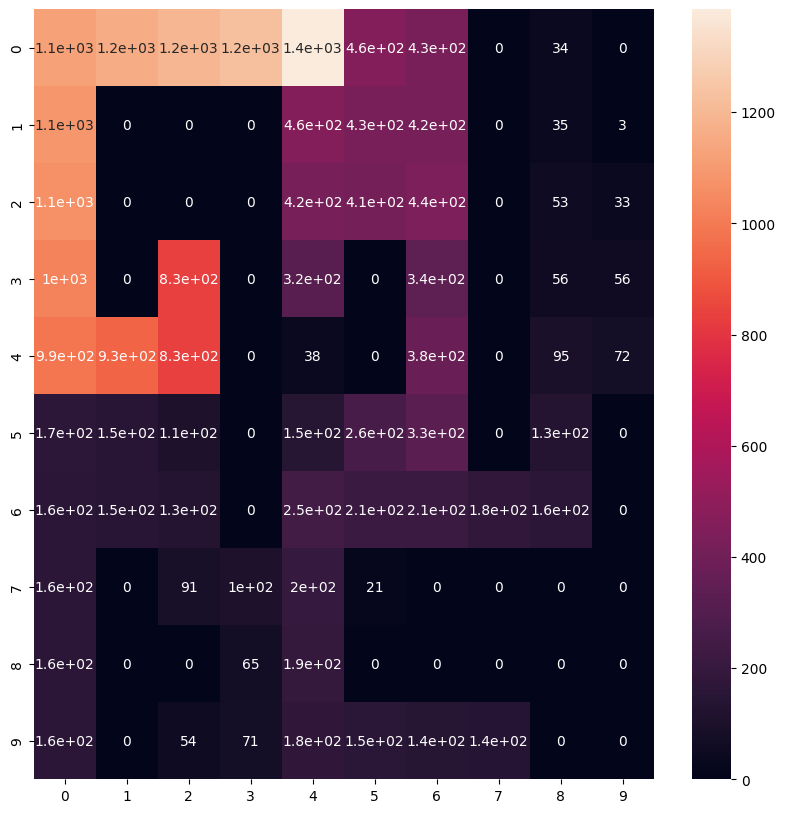

In [522]:
#@title heatmap of # of each state visited for all episodes
# write your code here
# heat map of number of times each state is visited
import seaborn as sns

visit_count_array = np.zeros((num_rows, num_cols))
for (row, col), count in states_visit_count.items():
    visit_count_array[row, col] = count


# plt.figure(figsize(10,10))
plt.figure(figsize=(10,10))
sns.heatmap(visit_count_array, annot=True)
plt.show()


4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

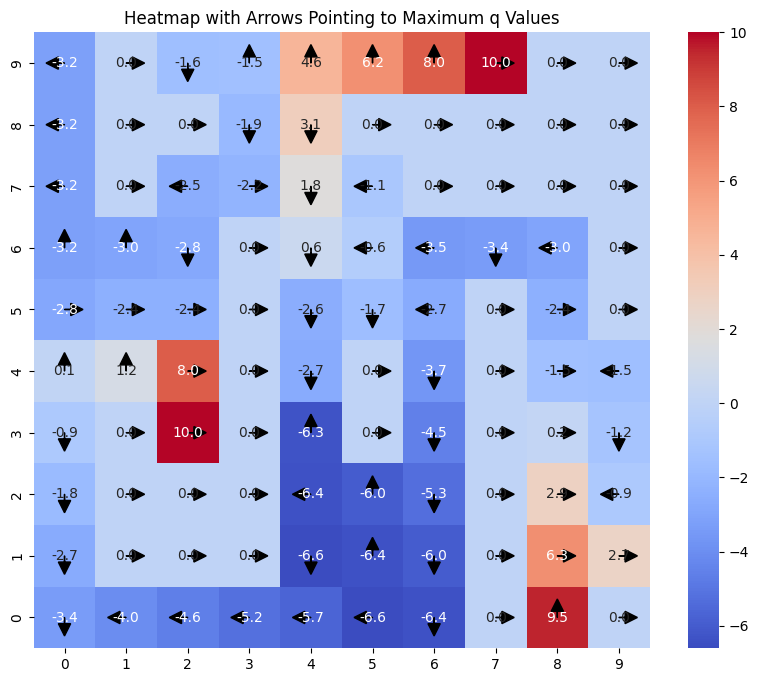

In [523]:
# write your code hereimport numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

heatmap_data = np.zeros((10, 10))

# Populate the heatmap data with the maximum q value for each state
for (i, j), actions in q.items():
    heatmap_data[i, j] = max(actions.values())

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, square=True)

# Adding arrows pointing to the maximum q value of each state
for (i, j), actions in q.items():
    max_action = max(actions, key=actions.get)
    if max_action == 0:  # Right
        dx, dy = 1, 0
    elif max_action == 1:  # Up
        dx, dy = 0, -1
    elif max_action == 2:  # Left
        dx, dy = -1, 0
    elif max_action == 3:  # Down
        dx, dy = 0, 1
    plt.arrow(j + 0.5, i + 0.5, dx * 0.3, dy * 0.3, color='black', head_width=0.2, head_length=0.2, length_includes_head=True)

plt.title("Heatmap with Arrows Pointing to Maximum q Values")
plt.gca().invert_yaxis()  # To match the grid orientation
plt.show()


In [524]:
#@title avg_reward ( on episode )
avg_reward = np.mean(list(episodic_reward_list.values()))
print(avg_reward)

-16.705


In [525]:
#@title avg steps ( on episode )
avg_number_steps_to_reach_goal = np.mean(list(episodic_steps_list.values()))
print(avg_number_steps_to_reach_goal)

22.455


### all Configuration for SARSA


In [526]:
configurations_ = [{'alpha': 0.001, 'gamma': 0.7, 'epsilon': 0.001},
                            {'alpha': 0.01, 'gamma': 0.8, 'epsilon': 0.01},
                            {'alpha': 0.1, 'gamma': 0.9, 'epsilon': 0.05},
                            {'alpha': 1, 'gamma': 1, 'epsilon': 0.1},
                            {'alpha': 0.001, 'gamma': 0.7, 'epsilon': 0.001},
                            {'alpha': 0.01, 'gamma': 0.8, 'epsilon': 0.01},
                            {'alpha': 0.1, 'gamma': 0.9, 'epsilon': 0.05},
                            {'alpha': 1, 'gamma': 1, 'epsilon': 0.1},]

In [527]:
param_sarsa = {}
for i in range(8):
  episodic_reward_list, episodic_steps_list, states_visit_count, q = sarsa(configurations_[i], 100)
  param_sarsa[i] = [np.mean(list(episodic_reward_list.values())),np.mean(list(episodic_steps_list.values()))]

In [528]:
param_sarsa

{0: [-457.96, 445.46],
 1: [-276.23, 268.53],
 2: [-109.04, 101.99],
 3: [-56.95, 51.5],
 4: [-457.94, 445.44],
 5: [-278.32, 272.72],
 6: [-106.09, 103.29],
 7: [-55.87, 48.92]}

### SARSA with best para


In [529]:
conf={'alpha': 1, 'gamma': 1, 'epsilon': 0.1}

# Call the SARSA function
episodic_reward_list, episodic_steps_list, states_visit_count, q = sarsa(conf, 1000)
# print(reward)

1. Plot reward curves (during the training phase with the best hyperparameters).

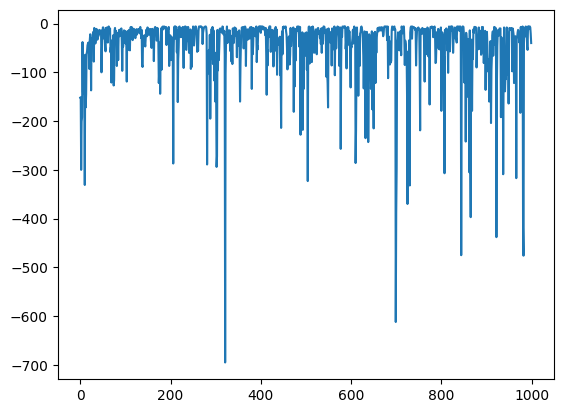

In [530]:
#@title episode # vs Reward
# write your code here
# on x-axis episode number, and on y-axis reward value
import matplotlib.pyplot as plt
plt.plot(episodic_reward_list.keys(), episodic_reward_list.values())
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

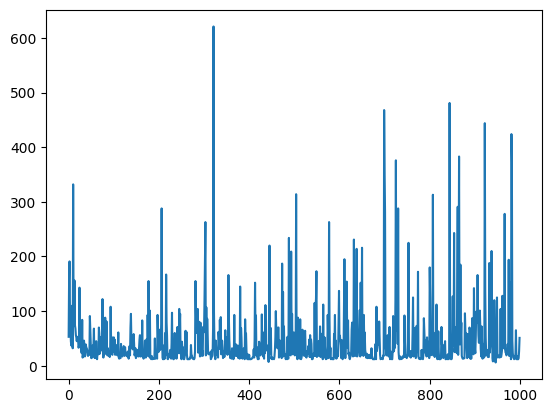

In [531]:
#@title episode # vs steps
# write your code here
# on x-axis the episode number, and on y-axis number of steps to reach the goal
plt.plot(episodic_steps_list.keys(), episodic_steps_list.values())
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

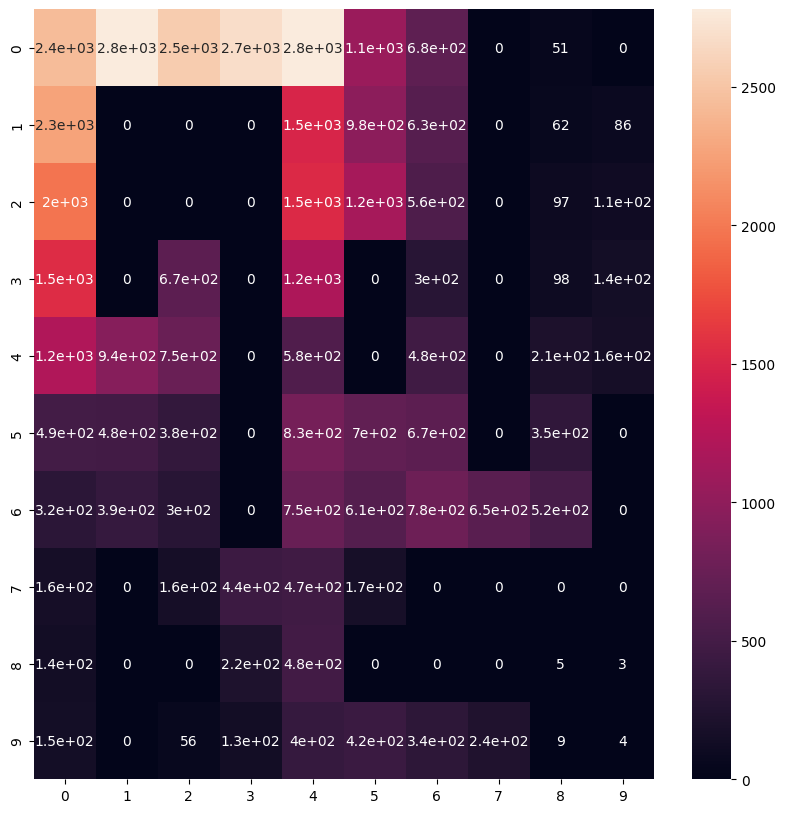

In [532]:
#@title heatmap of # of each state visited for all episodes
# write your code here
# heat map of number of times each state is visited
import seaborn as sns

visit_count_array = np.zeros((num_rows, num_cols))
for (row, col), count in states_visit_count.items():
    visit_count_array[row, col] = count


# plt.figure(figsize(10,10))
plt.figure(figsize=(10,10))
sns.heatmap(visit_count_array, annot=True)
plt.show()


4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

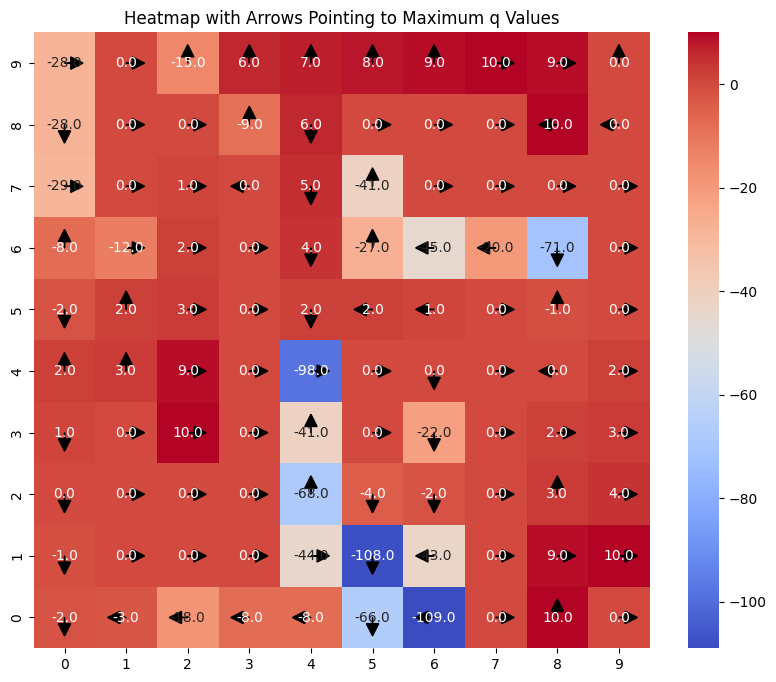

In [533]:
# write your code hereimport numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

heatmap_data = np.zeros((10, 10))

# Populate the heatmap data with the maximum q value for each state
for (i, j), actions in q.items():
    heatmap_data[i, j] = max(actions.values())

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, square=True)

# Adding arrows pointing to the maximum q value of each state
for (i, j), actions in q.items():
    max_action = max(actions, key=actions.get)
    if max_action == 0:  # Right
        dx, dy = 1, 0
    elif max_action == 1:  # Up
        dx, dy = 0, -1
    elif max_action == 2:  # Left
        dx, dy = -1, 0
    elif max_action == 3:  # Down
        dx, dy = 0, 1
    plt.arrow(j + 0.5, i + 0.5, dx * 0.3, dy * 0.3, color='black', head_width=0.2, head_length=0.2, length_includes_head=True)

plt.title("Heatmap with Arrows Pointing to Maximum q Values")
plt.gca().invert_yaxis()  # To match the grid orientation
plt.show()


In [534]:
#@title avg_reward ( on episode )
avg_reward = np.mean(list(episodic_reward_list.values()))
print(avg_reward)

-46.384


In [535]:
#@title avg steps ( on episode )
avg_number_steps_to_reach_goal = np.mean(list(episodic_steps_list.values()))
print(avg_number_steps_to_reach_goal)

46.444


### (2) Q_Learning with best para


#### Configuration Parameters

In [536]:
param_q_learning = {}
for i in range(8):
  episodic_reward_list, episodic_steps_list, states_visit_count, q = q_learning(configurations_[i], 100)
  param_q_learning[i] = [np.mean(list(episodic_reward_list.values())),np.mean(list(episodic_steps_list.values()))]
param_q_learning

{0: [-458.04, 445.54],
 1: [-276.54, 270.94],
 2: [-101.83, 97.68],
 3: [-39.91, 35.26],
 4: [-457.94, 445.44],
 5: [-273.6, 267.0],
 6: [-101.04, 97.19],
 7: [-39.74, 33.29]}

In [537]:
conf={'alpha': 1, 'gamma': 1, 'epsilon': 0.1}

# Call the SARSA function
episodic_reward_list, episodic_steps_list, states_visit_count, q = q_learning(conf, 1000)
# print(reward)

1. Plot reward curves (during the training phase with the best hyperparameters).

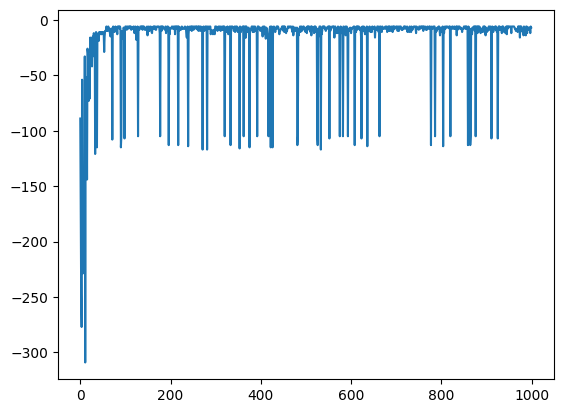

In [538]:
#@title episode # vs Reward
# write your code here
# on x-axis episode number, and on y-axis reward value
import matplotlib.pyplot as plt
plt.plot(episodic_reward_list.keys(), episodic_reward_list.values())
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

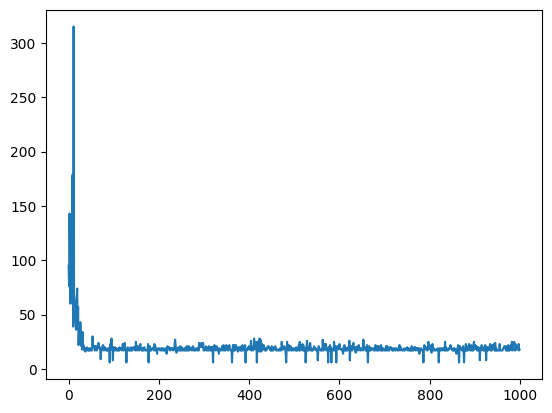

In [539]:
#@title episode # vs steps
# write your code here
# on x-axis the episode number, and on y-axis number of steps to reach the goal
plt.plot(episodic_steps_list.keys(), episodic_steps_list.values())
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

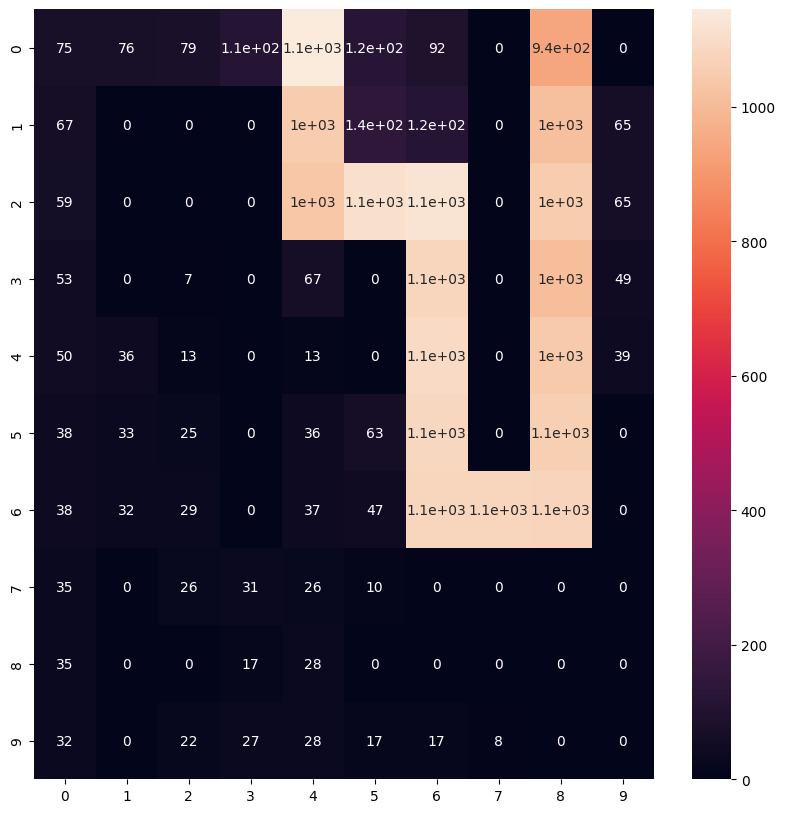

In [540]:
#@title heatmap of # of each state visited for all episodes
# write your code here
# heat map of number of times each state is visited
import seaborn as sns

visit_count_array = np.zeros((num_rows, num_cols))
for (row, col), count in states_visit_count.items():
    visit_count_array[row, col] = count


# plt.figure(figsize(10,10))
plt.figure(figsize=(10,10))
sns.heatmap(visit_count_array, annot=True)
plt.show()


4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

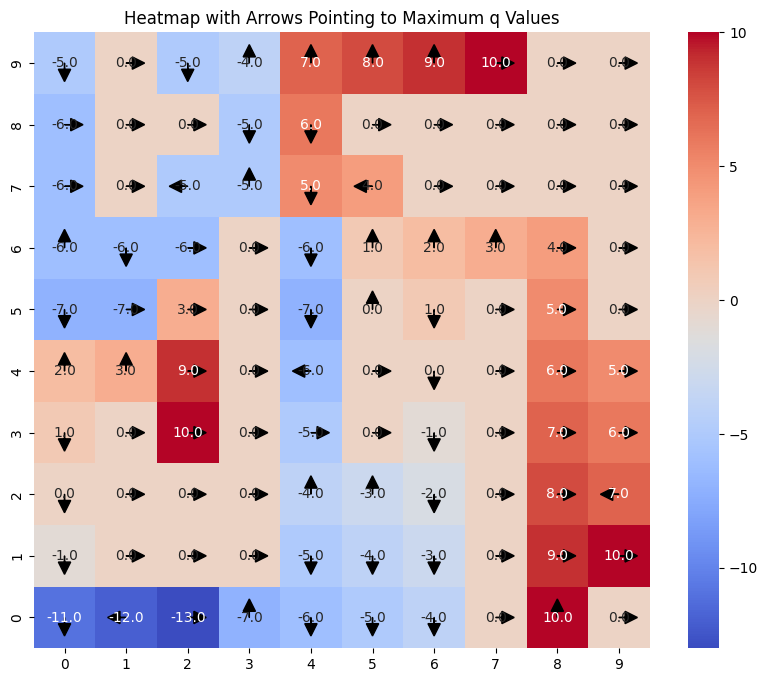

In [541]:
# write your code hereimport numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

heatmap_data = np.zeros((10, 10))

# Populate the heatmap data with the maximum q value for each state
for (i, j), actions in q.items():
    heatmap_data[i, j] = max(actions.values())

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, square=True)

# Adding arrows pointing to the maximum q value of each state
for (i, j), actions in q.items():
    max_action = max(actions, key=actions.get)
    if max_action == 0:  # Right
        dx, dy = 1, 0
    elif max_action == 1:  # Up
        dx, dy = 0, -1
    elif max_action == 2:  # Left
        dx, dy = -1, 0
    elif max_action == 3:  # Down
        dx, dy = 0, 1
    plt.arrow(j + 0.5, i + 0.5, dx * 0.3, dy * 0.3, color='black', head_width=0.2, head_length=0.2, length_includes_head=True)

plt.title("Heatmap with Arrows Pointing to Maximum q Values")
plt.gca().invert_yaxis()  # To match the grid orientation
plt.show()


In [542]:
#@title avg_reward ( on episode )
avg_reward = np.mean(list(episodic_reward_list.values()))
print(avg_reward)

-15.438


In [543]:
#@title avg steps ( on episode )
avg_number_steps_to_reach_goal = np.mean(list(episodic_steps_list.values()))
print(avg_number_steps_to_reach_goal)

20.213


## Analysis [36 Marks]

### SARSA [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Hyper para chose: {'alpha': 1, 'gamma': 1, 'epsilon': 0.1}
Your Answer: I did mean of total reward (not discounted) over all episodes and these parameters are giving the best result

In [544]:
# Optional: any supplementary code

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

In [545]:
# Optional: any supplementary code

Optional Comments:

### Q Learning [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Hyper para chose: {'alpha': 1, 'gamma': 1, 'epsilon': 0.1}
Your Answer: I did mean of total reward (not discounted) over all episodes and these parameters are giving the best result

In [546]:
# Optional: any supplementary code

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

In [547]:
# Optional: any supplementary code

Optional Comments:

# diff. between sarsa and q_learning I see:
I am adding it here Because I think its the most important!

in q learning the required step to converge is "relatively" with sarsa lesse.

SARSA took very high steps for each episode to converge.

I think this is because of choosing Max.Q value over all possible action in the TD update rule in q-learning